In [1]:
%set_env CUDA_VISIBLE_DEVICES=1

from timeit import default_timer
from src.models.ResNet import *
from src.utils.trainer import *
from src.utils.tools import *
from src.utils.splitNN import *
from src.utils.dataloader import * 
from torch.multiprocessing import set_start_method
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.optim import Adam, SGD
from torch import tensor
from torch import nn

import matplotlib.pyplot as plt
import pandas as pd
import syft as sy
import torch
import os
import gc

env: CUDA_VISIBLE_DEVICES=1
{'apple': 0, 'aquarium_fish': 1, 'baby': 2, 'bear': 3, 'beaver': 4, 'bed': 5, 'bee': 6, 'beetle': 7, 'bicycle': 8, 'bottle': 9, 'bowl': 10, 'boy': 11, 'bridge': 12, 'bus': 13, 'butterfly': 14, 'camel': 15, 'can': 16, 'castle': 17, 'caterpillar': 18, 'cattle': 19, 'chair': 20, 'chimpanzee': 21, 'clock': 22, 'cloud': 23, 'cockroach': 24, 'couch': 25, 'crab': 26, 'crocodile': 27, 'cup': 28, 'dinosaur': 29, 'dolphin': 30, 'elephant': 31, 'flatfish': 32, 'forest': 33, 'fox': 34, 'girl': 35, 'hamster': 36, 'house': 37, 'kangaroo': 38, 'keyboard': 39, 'lamp': 40, 'lawn_mower': 41, 'leopard': 42, 'lion': 43, 'lizard': 44, 'lobster': 45, 'man': 46, 'maple_tree': 47, 'motorcycle': 48, 'mountain': 49, 'mouse': 50, 'mushroom': 51, 'oak_tree': 52, 'orange': 53, 'orchid': 54, 'otter': 55, 'palm_tree': 56, 'pear': 57, 'pickup_truck': 58, 'pine_tree': 59, 'plain': 60, 'plate': 61, 'poppy': 62, 'porcupine': 63, 'possum': 64, 'rabbit': 65, 'raccoon': 66, 'ray': 67, 'road': 68

In [2]:
torch.manual_seed(0)

client_ids = list(range(0, 6))
iid_client = 5

data_paths = {}
for c in client_ids:
    data_paths[c] = f'data/clients/client{c+1}'
data_paths[iid_client] = 'data'
    
save_path = 'results/fashion-mnist/iid'

# To get around the PyTorch issue described by me at:
# https://github.com/OpenMined/PySyft/issues/3848
# This, however, leads to inefficient use of GPU memory
# and problems related to multiprocessing

torch.set_default_tensor_type(torch.cuda.FloatTensor)
hook = sy.TorchHook(torch)

server_model = ResNetServer18(num_classes=10)
client_model = ResNetClient(num_channels=1)

criterion = nn.NLLLoss(reduction='mean')

optim = SGD
optim_params = {
    'lr' : 0.1, 
    'momentum' : 0.9, 
    'weight_decay' :  0.0001
}

scheduler = MultiStepLR
scheduler_params = {
    'milestones': [75],
    'gamma': 0.2, 
}

dataloader_params = {
    'shuffle' : True,
    'num_workers' : 8,
}

batch_size = 512
batch_sizes = {
    0: int(0.4 * batch_size),
    1: int(0.3 * batch_size),
    2: int(0.1 * batch_size),
    3: int(0.1 * batch_size),
    4: int(0.1 * batch_size),
    iid_client: batch_size,
}

# PyTorch multiprocessing errors out with DataLoader tensors created on GPU 
# (as with torch.set_default_tensor_type(torch.cuda.FloatTensor)) and num_workers > 0.
# Therefore, we check if this is the case, and if so, change the spawn method. 
# More details at https://pytorch.org/docs/master/notes/multiprocessing.html
if torch.tensor([0]).is_cuda and dataloader_params['num_workers'] > 0:
    set_start_method('spawn', force=True)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Workers are automatically put on to the appropriate devices and clients
server = init_worker('server', server_model, hook, device, requires_grad=True) 

clients = {}
clients[iid_client] = init_worker('client_'+str(5), client_model, hook, device, requires_grad=True)
for c in client_ids[:-1]:
    clients[c] = clients[iid_client]

splitNN = SplitNN(clients, server)
criterion = criterion.to(device)

# Optimizers
server_optim = optim(splitNN.server.parameters(), **optim_params)
client_optims = {}
for c, client in splitNN.clients.items():
    client_optims[c] = optim(client.parameters(), **optim_params)

split_optim = SplitOptimizer(client_optims, server_optim)

# Schedulers
server_scheduler = scheduler(split_optim.server, **scheduler_params)
client_schedulers = {}
for c, client_optim in split_optim.clients.items():
    client_schedulers[c] = scheduler(client_optim, **scheduler_params)

split_scheduler = SplitScheduler(client_schedulers, server_scheduler)
    
# Get the data
dataloaders = {}
for c in client_ids:
    dataloaders[c] = {}
    if c == iid_client:
        dataloaders[c]['train'] = MNIST_dataloader(data_paths[c], batch_size=batch_sizes[c], 
                                                   train=True, **dataloader_params)
    dataloaders[c]['val'] = MNIST_dataloader(data_paths[c], batch_size=batch_sizes[c], 
                                             train=False, **dataloader_params)

trainer = SplitTrainer(client_ids=client_ids, splitNN=splitNN, split_optim=split_optim,
                       split_scheduler=split_scheduler, dataloaders=dataloaders, criterion=criterion, 
                       num_epochs=50, save_path=save_path, verbose=2, device=device)

In [2]:
stats = trainer.train_sequential(train_clts=[iid_client], val_clts=client_ids[:-1])

NameError: name 'trainer' is not defined

In [4]:
def plot_val_loss(stats, save_path):
    val = stats['val']
    val_acc = pd.DataFrame(val['accuracy'])
    val_acc['Epoch'] = val_acc.index.values
    ax = val_acc.plot(x='Epoch', y=client_ids[:-1] + ['global'], kind='line')
    ax.set_ylabel("Accuracy")
    ax.legend(['Client 0', 'Client 1', 'Client 2', 'Client 3', 'Client 4', 'global'] + ['Global'])
    ax.figure.savefig(os.path.join(save_path, 'val_acc.png'))
    
    val_acc = pd.DataFrame(val['loss'])
    val_acc['Epoch'] = val_acc.index.values
    ax = val_acc.plot(x='Epoch', y=client_ids[:-1], kind='line')
    ax.set_ylabel("Loss")
    ax.legend([f"Client {i}" for i in client_ids[:-1]])
    ax.figure.savefig(os.path.join(save_path, 'val_loss.png'))

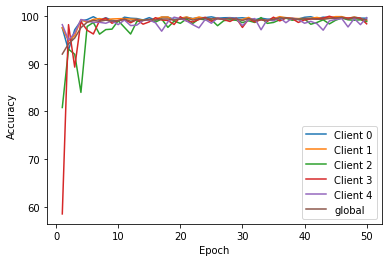

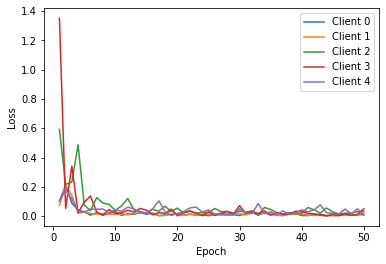

In [5]:
stats = torch.load('results/fashion-mnist/iid/epoch_50/server_trained_on_client_5.pth')['stats']
plot_val_loss(stats, save_path)